In [1]:
#%pip install pandas
import pandas as pd
#%pip install emot==2.1
import re
import string
import json
from emot.emo_unicode import UNICODE_EMO, EMOTICONS

In [2]:
# Function for converting emoticons into word
def convert_emoticons(text):
    for emot in EMOTICONS:
        text = re.sub(u'('+emot+')', "_".join(EMOTICONS[emot].replace(",","").split()), text)
    return text

# Function for converting emoji into word
def convert_emojis(text):
    for emot in UNICODE_EMO:
        text = text.replace(emot, "_".join(UNICODE_EMO[emot].replace(",","").replace(":","").split()))
    return text

In [3]:
df = pd.read_csv("data_huang_devansh.csv", encoding='utf8')
df["Content"] = df["Content"].astype(str)

In [4]:
HTTP_PATTERN = re.compile(".*http.*")
def remove_links(txt):
    # Split the string into words
    words = txt.split()
    
    # Use regular expression to find words containing "http"
    http_words = [word for word in words if HTTP_PATTERN.match(word)]
    count = len(http_words)
    
    for word in http_words:
        words.remove(word)
    
    txt = ' '.join(words).replace("</a>","").replace("<a","").replace("</a", "")
    
    # Join the remaining words back into a string
    return txt,count

df["Content"],df["Links"] = zip(*df["Content"].apply(remove_links))

In [5]:
df["Length"]=df["Content"].apply(lambda txt: len(txt))
df.tail(50)

,Content,Label,Links,Length
842285,"""LA VERDADA SI MUERE EL PRINCIPE NI ME VA NI M...",0,0,123
842286,"""In the recent Occupy Wall Street protests by ...",0,0,432
842287,"""you are a frightened infant who never saw com...",1,0,77
842288,"""I'm so tired of some people cramming their re...",1,0,214
842289,"""IKR~~!!!! i know about them and other close f...",0,0,427
842290,"""You are an idiot. Romney is not going to give...",1,0,83
842291,"""No, people have a right to speak, no matter h...",1,0,66
842292,"""I hope you are having a girl :) are u gonna f...",0,0,62
842293,"""too funny. And I know a couple of dogs who wo...",0,0,61
842294,"""Hell yeagh man kluv these hot pig fukkas-luv ...",0,0,109


In [6]:
df["Upper_case"]=df["Content"].apply(lambda txt: sum(1 for c in txt if c.isupper()))
df.tail(50)

,Content,Label,Links,Length,Upper_case
842285,"""LA VERDADA SI MUERE EL PRINCIPE NI ME VA NI M...",0,0,123,93
842286,"""In the recent Occupy Wall Street protests by ...",0,0,432,9
842287,"""you are a frightened infant who never saw com...",1,0,77,1
842288,"""I'm so tired of some people cramming their re...",1,0,214,4
842289,"""IKR~~!!!! i know about them and other close f...",0,0,427,131
842290,"""You are an idiot. Romney is not going to give...",1,0,83,2
842291,"""No, people have a right to speak, no matter h...",1,0,66,1
842292,"""I hope you are having a girl :) are u gonna f...",0,0,62,1
842293,"""too funny. And I know a couple of dogs who wo...",0,0,61,2
842294,"""Hell yeagh man kluv these hot pig fukkas-luv ...",0,0,109,2


In [7]:
#Convert emojis to text
df["Content"] = df["Content"].apply(convert_emojis)
df.head(5)

,Content,Label,Links,Length,Upper_case
0,`- This is not ``creative``. Those are the dic...,0,0,2371,47
1,` :: the term ``standard model`` is itself les...,0,0,707,15
2,"True or false, the situation as of March 2002 ...",0,0,326,20
3,"Next, maybe you could work on being less conde...",0,0,421,10
4,This page will need disambiguation.,0,0,35,1


In [8]:
#Convert emoticons to text
df["Content"] = df["Content"].apply(convert_emoticons)
df.head(5)

,Content,Label,Links,Length,Upper_case
0,`- This is not ``creative``. Those are the dic...,0,0,2371,47
1,` :: the term ``standard model`` is itself les...,0,0,707,15
2,"True or false, the situation as of March 2002 ...",0,0,326,20
3,"Next, maybe you could work on being less conde...",0,0,421,10
4,This page will need disambiguation.,0,0,35,1


In [9]:
df["Hashtag"] = df["Content"].apply(lambda txt: sum(1 for word in txt.split() if word.startswith("#")))

In [10]:
#Remove special chars from the string (except quotation marks)
def remove_trailing_chars(txt):
    new_str = []
    for x in txt.split():
        new_str.append(str(x).lstrip('_\-;%()|+&=*%.,!?:$[]/^`~<>\'"').rstrip('"_\-;%()|+&=*%.,!?:#$@[]/^~`<>\'"')
                       .replace("\\n"," ").replace("\\\\xa0"," ").replace("\\r"," ").replace("\\'","'")
                       .replace("\\\\xc2"," ").replace("\\xa0"," ").replace("\\xc2"," ").replace("\\",""))
        
    return ' '.join(new_str)

In [11]:
with open("Contractions.json",'r')as f:
        contractions = json.load(f)

df["Content"] = df["Content"].apply(remove_trailing_chars)
df.tail(50)

,Content,Label,Links,Length,Upper_case,Hashtag
842285,LA VERDADA SI MUERE EL PRINCIPE NI ME VA NI ME...,0,0,123,93,0
842286,In the recent Occupy Wall Street protests by t...,0,0,432,9,0
842287,you are a frightened infant who never saw comb...,1,0,77,1,0
842288,I'm so tired of some people cramming their rel...,1,0,214,4,0
842289,IKR i know about them and other close friendsh...,0,0,427,131,0
842290,You are an idiot Romney is not going to give s...,1,0,83,2,0
842291,No people have a right to speak no matter how ...,1,0,66,1,0
842292,I hope you are having a girl Happy_face_or_smi...,0,0,62,1,0
842293,too funny And I know a couple of dogs who woul...,0,0,61,2,0
842294,Hell yeagh man kluv these hot pig fukkas-luv t...,0,0,109,2,0


In [12]:
def replace_contractions(txt):
    txt = txt.split()
    new_string = [contractions.get(word.lower(),word) for word in txt]
    return ' '.join(new_string)

In [13]:
df["Content"] = df["Content"].apply(replace_contractions)
df.tail(50)

,Content,Label,Links,Length,Upper_case,Hashtag
842285,LA VERDADA SI MUERE EL PRINCIPE no idea ME VA ...,0,0,123,93,0
842286,In the recent Occupy Wall Street protests by t...,0,0,432,9,0
842287,you are a frightened infant who never saw comb...,1,0,77,1,0
842288,i am so tired of some people cramming their re...,1,0,214,4,0
842289,i know really i know about them and other clos...,0,0,427,131,0
842290,You are an idiot Romney is not going to give s...,1,0,83,2,0
842291,No people have a right to speak no matter how ...,1,0,66,1,0
842292,I hope you are having a girl Happy_face_or_smi...,0,0,62,1,0
842293,too funny And I know a couple of dogs who woul...,0,0,61,2,0
842294,Hell yeagh man kluv these hot pig fukkas-luv t...,0,0,109,2,0


In [14]:
# Read the CSV file into a dataframe and extract the words into a set
profanities_df = pd.read_csv('Profanities.csv', header=None, names=['word'])
profanities = set(profanities_df['word'])

df["Profanities"] = df["Content"].apply(lambda txt: sum(txt.lower().count(word) for word in profanities))
df.tail(50)

,Content,Label,Links,Length,Upper_case,Hashtag,Profanities
842285,LA VERDADA SI MUERE EL PRINCIPE no idea ME VA ...,0,0,123,93,0,0
842286,In the recent Occupy Wall Street protests by t...,0,0,432,9,0,0
842287,you are a frightened infant who never saw comb...,1,0,77,1,0,0
842288,i am so tired of some people cramming their re...,1,0,214,4,0,1
842289,i know really i know about them and other clos...,0,0,427,131,0,2
842290,You are an idiot Romney is not going to give s...,1,0,83,2,0,0
842291,No people have a right to speak no matter how ...,1,0,66,1,0,0
842292,I hope you are having a girl Happy_face_or_smi...,0,0,62,1,0,0
842293,too funny And I know a couple of dogs who woul...,0,0,61,2,0,0
842294,Hell yeagh man kluv these hot pig fukkas-luv t...,0,0,109,2,0,2


In [15]:
df["User_mentions"] = df["Content"].apply(lambda txt: sum(1 for word in txt.split() if word.startswith('@')))
df.tail(50)

,Content,Label,Links,Length,Upper_case,Hashtag,Profanities,User_mentions
842285,LA VERDADA SI MUERE EL PRINCIPE no idea ME VA ...,0,0,123,93,0,0,0
842286,In the recent Occupy Wall Street protests by t...,0,0,432,9,0,0,0
842287,you are a frightened infant who never saw comb...,1,0,77,1,0,0,0
842288,i am so tired of some people cramming their re...,1,0,214,4,0,1,0
842289,i know really i know about them and other clos...,0,0,427,131,0,2,0
842290,You are an idiot Romney is not going to give s...,1,0,83,2,0,0,0
842291,No people have a right to speak no matter how ...,1,0,66,1,0,0,0
842292,I hope you are having a girl Happy_face_or_smi...,0,0,62,1,0,0,0
842293,too funny And I know a couple of dogs who woul...,0,0,61,2,0,0,0
842294,Hell yeagh man kluv these hot pig fukkas-luv t...,0,0,109,2,0,2,0


In [16]:
df["Emoji"]=df["Content"].apply(lambda txt: sum(1 for word in txt.split() if "_" in word
                                                and word[0].isupper() and word[0].isalpha()))
df.tail(50)

,Content,Label,Links,Length,Upper_case,Hashtag,Profanities,User_mentions,Emoji
842285,LA VERDADA SI MUERE EL PRINCIPE no idea ME VA ...,0,0,123,93,0,0,0,0
842286,In the recent Occupy Wall Street protests by t...,0,0,432,9,0,0,0,0
842287,you are a frightened infant who never saw comb...,1,0,77,1,0,0,0,0
842288,i am so tired of some people cramming their re...,1,0,214,4,0,1,0,0
842289,i know really i know about them and other clos...,0,0,427,131,0,2,0,0
842290,You are an idiot Romney is not going to give s...,1,0,83,2,0,0,0,0
842291,No people have a right to speak no matter how ...,1,0,66,1,0,0,0,0
842292,I hope you are having a girl Happy_face_or_smi...,0,0,62,1,0,0,0,1
842293,too funny And I know a couple of dogs who woul...,0,0,61,2,0,0,0,0
842294,Hell yeagh man kluv these hot pig fukkas-luv t...,0,0,109,2,0,2,0,0


In [17]:
df["Digits"] = df["Content"].apply(lambda txt: sum(1 for c in txt if c.isdigit()))
df.describe()

,Label,Links,Length,Upper_case,Hashtag,Profanities,User_mentions,Emoji,Digits
count,842335.000000,842335.000000,842335.000000,842335.000000,842335.000000,842335.000000,842335.000000,842335.000000,842335.000000
mean,0.158718,0.053225,297.714794,13.821526,0.282700,1.147646,0.200660,0.075588,2.013153
std,0.365413,0.420897,558.863353,117.404282,1.265872,15.736362,0.986306,0.555284,13.692822
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,68.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,129.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,297.000000,11.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,85.000000,19906.000000,10501.000000,380.000000,2000.000000,50.000000,134.000000,4246.000000


In [24]:
def clear_text(input_string):
    # Create a translation table with all special characters and digits mapped to None
    translation_table = str.maketrans('', '', string.punctuation + string.digits)
    
    # Split the input string into words and remove special characters and digits from each word
    words = [word.translate(translation_table) for word in input_string.split()]
    
    # Join the cleaned words back into a string
    cleaned_string = ' '.join(words).lower()
    return cleaned_string

In [27]:
#%pip install nltk
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

# Get stopwords for English
stop = stopwords.words('english')

df['Content'] = df['Content'].apply(clear_text)
df['Content'] = df['Content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df.tail(50)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\filip\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Content,Label,Links,Length,Upper_case,Hashtag,Profanities,User_mentions,Emoji,Digits
842285,la verdada si muere el principe idea va idea v...,0,0,123,93,0,0,0,0,0
842286,recent occupy wall street protests left comedi...,0,0,432,9,0,0,0,0,18
842287,frightened infant never saw combat young littl...,1,0,77,1,0,0,0,0,0
842288,tired people cramming religion peoples faces n...,1,0,214,4,0,1,0,0,0
842289,know really know close friendship group since ...,0,0,427,131,0,2,0,0,3
842290,idiot romney going give someone making k tax rate,1,0,83,2,0,0,0,0,4
842291,people right speak matter stupid,1,0,66,1,0,0,0,0,0
842292,hope girl happyfaceorsmiley going find,0,0,62,1,0,0,0,1,0
842293,funny know couple dogs would love,0,0,61,2,0,0,0,0,0
842294,hell yeagh man kluv hot pig fukkasluv get wiht...,0,0,109,2,0,2,0,0,0


In [46]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import numpy as np

def histogram_profanities(dataframe_col,profanities):
    vectorizer = CountVectorizer()
    bow_matrix = vectorizer.fit_transform(dataframe_col)

    vocabulary = vectorizer.get_feature_names_out()
    
    # Get indices of profanities in the vocabulary
    profanity_indices = [np.where(vocabulary == word)[0][0] for word in profanities if word in vocabulary]

    # Calculate profanity frequencies
    profanity_frequencies = bow_matrix[:, profanity_indices].toarray().sum(axis=0)

    # Sort profanities and frequencies in descending order
    sorted_indices = np.argsort(profanity_frequencies)[::-1]
    sorted_profanities = [profanities[i] for i in sorted_indices]
    sorted_frequencies = profanity_frequencies[sorted_indices]

    # Plot the top 10 most used profanities
    plt.bar(sorted_profanities[:10], sorted_frequencies[:10])
    plt.xlabel('Profanity Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()


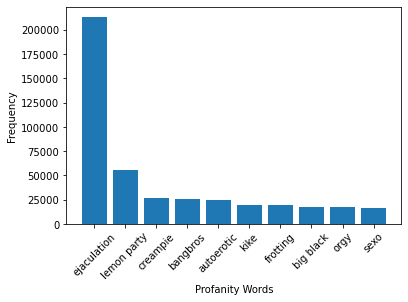

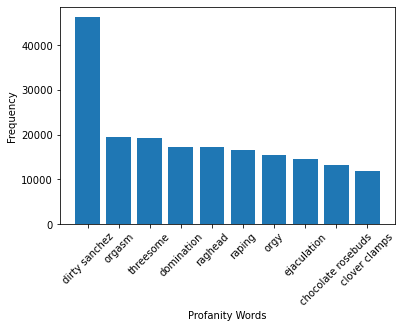

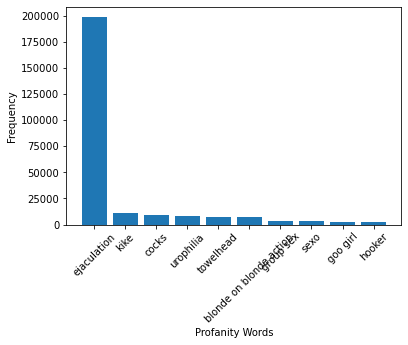

In [48]:
histogram_profanities(df["Content"],list(profanities))

#Hate speech subset graph
histogram_profanities(df[df["Label"]==1]["Content"],list(profanities))
#NON hate speech subset graph
histogram_profanities(df[df["Label"]==0]["Content"],list(profanities))

In [ ]:
def histogram_words(dataframe):
    
    words = dataframe.str.split().explode()

    # Flatten the list of words
    word_list = [word for sublist in words for word in sublist]

    # Count the frequency of each word using Counter
    word_counts = Counter(word_list)

    # Get the top 10 most frequent words and their counts
    top_words = word_counts.most_common(10)
    words, counts = zip(*top_words)

    # Plot the histogram
    plt.bar(words, counts)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title('Top 10 Most Frequent Words')
    plt.xticks(rotation=45)
    plt.show()


In [ ]:
histogram_words(df["Content"])
histogram_words(df[df["Label"]==1]["Content"])
histogram_words(df[df["Label"]==0]["Content"])

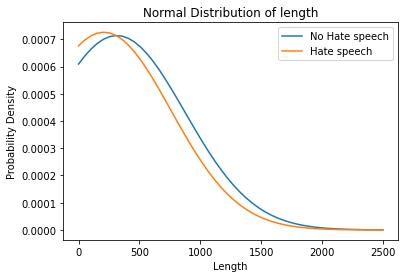

In [117]:
from scipy.stats import norm

# Filter the DataFrame by Label values
label_0_lengths = df[df["Label"] == 0]["Length"]
label_1_lengths = df[df["Label"] == 1]["Length"]

# Fit a normal distribution to the length values
mean_0, std_0 = norm.fit(label_0_lengths)
mean_1 , std_1 = norm.fit(label_1_lengths)
# Generate x-values for the plot
x_0 = np.linspace(label_0_lengths.min(), 3000)#label_0_lengths.max())
x_1 = np.linspace(label_1_lengths.min(), 3000)#label_1_lengths.max())
# Calculate the corresponding y-values using the fitted distribution
y_0 = norm.pdf(x_0, mean_0, std_0)
y_1 = norm.pdf(x_1, mean_1, std_1)
# Plot the normal distribution
plt.plot(x_0, y_0, label="No Hate speech")
plt.plot(x_1, y_1, label="Hate speech")
plt.xlabel("Length")
plt.ylabel("Probability Density")
plt.title("Normal Distribution of length")
plt.legend()
plt.show()


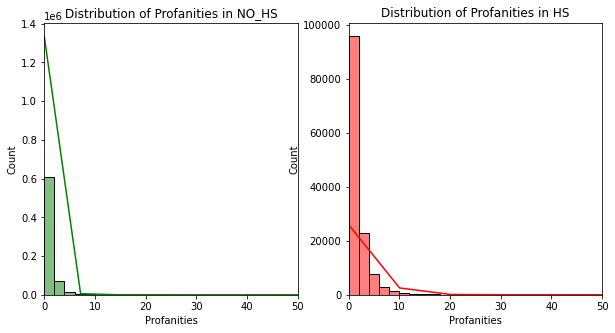

In [116]:
import seaborn as sns

plt.figure(figsize=(10, 5))

p = plt.subplot(1, 2, 1)
p.set_xlim(df[df['Label'] == 0]['Profanities'].min(), 50)
sns.histplot(df[df['Label'] == 0]['Profanities'], binwidth=2, color='green', kde=True)
plt.title('Distribution of Profanities in NO_HS')

g = plt.subplot(1, 2, 2)
g.set_xlim(df[df['Label'] == 1]['Profanities'].min(), 50)
sns.histplot(df[df['Label'] == 1]['Profanities'], binwidth=2, color='red', kde=True)
plt.title('Distribution of Profanities in HS')

plt.show()


In [1]:
# Convert DataFrame to NumPy array
attributes = df.drop(["Content","Label"],axis=1).to_numpy()

# Calculate correlation matrix
correlation_matrix = np.corrcoef(attributes, rowvar=False)

# Create heatmap
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")

# Set labels and title
plt.xticks(np.arange(attributes.shape[1]), labels=df.columns)
plt.yticks(np.arange(attributes.shape[1]), labels=df.columns)
plt.title("Correlation Heatmap")

# Show the plot
plt.show()


NameError: name 'df' is not defined

In [ ]:
# Create scatter plot
plt.scatter(df["Length"], df["Profanities"])

# Set labels and title
plt.xlabel("Length")
plt.ylabel("Profanities")
plt.title("Scatter Plot - Length vs Profanities")

# Show the plot
plt.show()


In [ ]:
#TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming 'data' is your original dataframe and 'Content' is the text column
text_data = df['Content']

# Create an instance of TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fit the vectorizer to your text data and transform it into TF-IDF matrix
tfidf_matrix = vectorizer.fit_transform(text_data)

# Convert the TF-IDF matrix to a pandas DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names())

# Concatenate the TF-IDF DataFrame with the original dataframe
combined_data = pd.concat([df, tfidf_df], axis=1)


In [ ]:
import numpy as np

def min_max_scaling(data):
    min_val = np.min(data)
    max_val = np.max(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data


df["Standardized_length"] = min_max_scaling(df["Length"])

Prossima mossa eseguire lemmatization (o stemming) (e magari cerca anche altri metodi) (prima normalizzare il testo). Come algoritmi Support vector machine, Bayesian classifier, random forest (cercane altri?)

Fare dei grafici e cercare gli attributi veramente significativi
Normalizzare il testo: togliere i caratteri speciali, scrivere tutto in minuscolo, rimuovere i numeri
Togliere le stopwords
Processare il testo con lemmatization o stemming
Bilanciare il dataset
Costruire TF-IDF dal testo ()
Provare vari classifiers